In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf /content/hr
!rm -rf /content/1.png
!rm -rf /content/hr_temp
!rm -rf /content/temp1
!rm -rf /content/temp2

In [ ]:
!cp -r /content/drive/MyDrive/hr /content/hr
!cp /content/drive/MyDrive/1.png /content/1.png
!cp -r /content/drive/MyDrive/hr_temp /content/hr_temp

cp: cannot stat '/content/drive/MyDrive/1.png': No such file or directory
cp: cannot stat '/content/drive/MyDrive/hr_temp': No such file or directory


In [ ]:
import numpy as np
import os
from torch.autograd import Variable
import cv2 as cv
import torch
import imageio


# Utils

In [ ]:



def calc_output_size(H, kernel_size, padding=0, dilation=1, stride=1):
    return ((H + 2 * padding - dilation * (kernel_size - 1) - 1) / stride) + 1


# Create annotation file
def build_index_file(dir="hr"):
    file_names = [[filename] for filename in os.listdir(dir)]

    np.savetxt(dir + "/" + dir + ".csv",
               file_names,
               delimiter=", ",
               fmt='% s',
               encoding="utf-8")


def crop_images(w, h, dir="hr"):
    file_names = [filename for filename in os.listdir(dir) if '.csv' not in filename]
    folder_hr = 'hr'
    for file in file_names:
        image = cv.imread(os.path.join(dir, file))
        img_size = image.shape
        x = img_size[1] / 2 - w / 2
        y = img_size[0] / 2 - h / 2
        crop_img = image[int(y):int(y + h), int(x):int(x + w)]
        cv.imwrite(os.path.join(folder_hr, file), crop_img)
    build_index_file(dir="hr")


def to_var(tensor, device):
    """Wraps a Tensor in a Variable, optionally placing it on the GPU.

        Arguments:
            tensor: A Tensor object.
            cuda: A boolean flag indicating whether to use the GPU.

        Returns:
            A Variable object, on the GPU if cuda==True.
    """

    return Variable(tensor.float()).cuda(device)


def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data.numpy()


def create_image_grid(array, ncols=None):
    """
    """
    num_images, channels, cell_h, cell_w = array.shape
    if not ncols:
        ncols = int(np.sqrt(num_images))
    nrows = int(np.math.floor(num_images / float(ncols)))
    result = np.zeros((cell_h * nrows, cell_w * ncols, channels), dtype=array.dtype)
    for i in range(0, nrows):
        for j in range(0, ncols):
            result[i * cell_h:(i + 1) * cell_h, j * cell_w:(j + 1) * cell_w, :] = array[i * ncols + j].transpose(1, 2,
                                                                                                                 0)

    if channels == 1:
        result = result.squeeze()
    return result


def gan_save_samples(data, iteration, opts):
    generated_images = to_data(data)

    grid = create_image_grid(generated_images)

    # merged = merge_images(X, fake_Y, opts)
    path = os.path.join(opts.sample_dir, 'sample-{:06d}.png'.format(iteration))
    imageio.imwrite(path, grid)
    print('Saved {}'.format(path))



# a = calc_output_size(256, 9, stride=1, padding=4)
# b = calc_output_size(a, 5, stride=1, padding=2)
# print(calc_output_size(b, 5, stride=1, padding=2))
#crop_images(128, 128)

## ESRGAN

In [ ]:
from torch import cat
from torch import nn
from torch import flatten
from torch import add

"""
Reference:
https://arxiv.org/pdf/1809.00219v2.pdf
"""
global_beta = 0.2


class Generator(nn.Module):
    def __init__(self, channels, kernel_size=3, stride=1, padding=1):
        super().__init__()

        self.conv0 = nn.Sequential(
            nn.Conv2d(channels, 64, (3, 3), stride=(stride, stride), padding=padding),
            nn.ReLU()
        )

        self.RRDB_layers = nn.Sequential(*[RRDB(64, 32, global_beta) for i in range(16)])

        self.conv1 = nn.Sequential(
            nn.Conv2d(64, 64, (kernel_size, kernel_size), stride=(stride, stride), padding=padding),
            nn.ReLU(inplace=True)
        )

        self.upSample0 = nn.Sequential(
            nn.Conv2d(64, 64 * 4, (1, 1), stride=(stride, stride)),
            nn.PixelShuffle(2),
            nn.ReLU(inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, (kernel_size, kernel_size), stride=(stride, stride), padding=padding),
            nn.ReLU(inplace=True)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, channels, (kernel_size, kernel_size), stride=(stride, stride), padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.conv0(x)
        x2 = self.RRDB_layers(x1)
        x3 = add(self.conv1(x2), x1)
        x4 = self.upSample0(x3)
        x5 = self.conv2(x4)
        return self.conv3(x5)


class Discriminator(nn.Module):
    def __init__(self, channels, kernel_size=3, stride=1, padding=1):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=(kernel_size, kernel_size), stride=(stride, stride), padding=padding,
                      bias=True),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.basicBlocks = nn.Sequential(
            DiscriminatorBlock(64, 64, kernel_size=4, stride=2, padding=padding),
            DiscriminatorBlock(64, 128, kernel_size=3, stride=stride, padding=padding),
            DiscriminatorBlock(128, 128, kernel_size=4, stride=2, padding=padding),
            DiscriminatorBlock(128, 256, kernel_size=3, stride=stride, padding=padding),
            DiscriminatorBlock(256, 256, kernel_size=4, stride=2, padding=padding),
            DiscriminatorBlock(256, 512, kernel_size=3, stride=stride, padding=padding),
            DiscriminatorBlock(512, 512, kernel_size=4, stride=2, padding=padding),
            DiscriminatorBlock(512, 512, kernel_size=3, stride=stride, padding=padding),
            DiscriminatorBlock(512, 512, kernel_size=4, stride=2, padding=padding),
        )

        self.block2 = nn.Sequential(
            nn.Linear(512 * 4 * 4, 100),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        layer1 = self.block1(x)
        block_out = self.basicBlocks(layer1)
        flattened = flatten(block_out, 1)
        return self.block2(flattened)


class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, kernel_size),
                      stride=(stride, stride), padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.block1(x)


class RRDB(nn.Module):
    def __init__(self, channels, growth_rate, beta):
        super().__init__()

        self.block0 = DenseBlock(channels, growth_rate)
        self.block1 = DenseBlock(channels, growth_rate)
        self.block2 = DenseBlock(channels, growth_rate)
        self.beta = beta

    def forward(self, x):
        x1 = self.block0(x)
        skip0 = self.beta * x1 + x

        x2 = self.block1(skip0)
        skip1 = self.beta * x2 + skip0

        x3 = self.block2(skip1)
        return (skip1 + self.beta * x3) * self.beta + x


class DenseBlock(nn.Module):
    """
    Follows the design used in: https://arxiv.org/pdf/1809.00219v2.pdf
    Original design: https://arxiv.org/pdf/1608.06993v5.pdf
    """

    def __init__(self, channels, growth_rate, kernel_size=3, stride=1, padding=1):
        super().__init__()

        self.conv0 = nn.Conv2d(channels, growth_rate, (kernel_size, kernel_size),
                               (stride, stride), padding)
        self.conv1 = nn.Conv2d(channels + growth_rate, growth_rate, (kernel_size, kernel_size),
                               (stride, stride), padding)
        self.conv2 = nn.Conv2d(channels + 2 * growth_rate, growth_rate, (kernel_size, kernel_size),
                               (stride, stride), padding)
        self.conv3 = nn.Conv2d(channels + 3 * growth_rate, growth_rate, (kernel_size, kernel_size),
                               (stride, stride), padding)
        self.conv4 = nn.Conv2d(channels + 3 * growth_rate, channels, (kernel_size, kernel_size),
                               (stride, stride), padding)

        self.LReLu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x1 = self.LReLu(self.conv0(x))
        x2 = self.LReLu(self.conv1(cat((x, x1), 1)))
        x3 = self.LReLu(self.conv2(cat((x, x1, x2), 1)))
        x4 = self.LReLu(self.conv3(cat((x, x1, x2, x3), 1)))
        return self.conv4(cat((x, x1, x2, x4), 1))


# SRCNN

In [19]:
"""
Reference:
https://arxiv.org/pdf/1501.00092.pdf
"""


class SRCNN(nn.Module):
    def __init__(self, channel, f1=9, f2=5, f3=5, n1=64, n2=32):

        super(SRCNN, self).__init__()
        self.channel = channel
        self.block1 = nn.Conv2d(channel, n1, kernel_size=(f1, f1), bias=True, padding=f1 // 2)
        self.block2 = nn.Conv2d(n1, n2, kernel_size=(f2, f2), bias=True, padding=f2 // 2)
        self.block3 = nn.Conv2d(n2, channel, kernel_size=(f3, f3), bias=True, padding=f3 // 2)
        self.activation = nn.ReLU(inplace=True)
        # self.upSample0 = nn.Sequential(
        #     nn.Conv2d(3, 3 * 4, (1, 1)),
        #     nn.PixelShuffle(2),
        #     nn.ReLU(inplace=True)
        # )

    def forward(self, x):
        x1 = self.activation(self.block1(x))
        x2 = self.activation(self.block2(x1))
        return self.block3(x2)


# Train

In [23]:
from matplotlib import pyplot as plt
import os
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision import transforms
from torch.optim import Adam
from torch.autograd import Variable
from torchvision.utils import save_image

random.seed(42)


class CustomData(Dataset):
    def __init__(self, model='SRCNN'):
        self.names = np.loadtxt('hr/hr.csv', dtype='str', delimiter=", ",
                                encoding="utf-8")

        self.names = [name for name in self.names if "csv" not in name]
        
        self.hrs = [read_image(os.path.join('hr', name)).float() / 255.0 for name in self.names]
        if model == 'SRCNN':
          self.lr_transform = transforms.Compose([transforms.Resize((64, 64)), 
                                                  transforms.Resize((128, 128))])
        else:
          self.lr_transform = transforms.Compose([transforms.Resize((64, 64))])
        self.lrs = [self.lr_transform(img) for img in self.hrs]

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        return self.lrs[idx], self.hrs[idx]


def train_SRCNN(args):
    """
    Train SRCNN model
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', torch.cuda.get_device_name(0))

    model = SRCNN(args['out_channels'])
    if torch.cuda.is_available():
        model.cuda(device)

    model.train()
    params = model.parameters()
    optimizer = Adam(params, args['learning_rate'], args['betas'])
    # train with mse loss
    loss = nn.MSELoss()
    dataloader = DataLoader(CustomData(), batch_size=args['batch_size'], shuffle=True, num_workers=0,
                            pin_memory=True)
    train_iter = iter(dataloader)
    train_loss = []

    best_loss = float('inf')
    best_model = None
    for i in range(args['epochs']):
        try:
            lr, hr = train_iter.next()
            lr, hr = to_var(lr, device), to_var(hr, device)

        except StopIteration:
            train_iter = iter(dataloader)
            lr, hr = train_iter.next()
            lr, hr = to_var(lr, device), to_var(hr, device)

        optimizer.zero_grad()
        g = model(lr)
        l = loss(g, hr)
        l.backward()
        optimizer.step()
        train_loss.append(l.item())

        if l.item() < best_loss:
          best_loss = l.item()
          best_model = model.state_dict()

        if i % 100 == 0:
            print('Iteration {}/{}, training loss: {}'.format(i, args['epochs'], l))

    plt.plot([i for i in range(args['epochs'])], train_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('SRCNN.png')
    pt_name = "SRCNN_lr_{}.pt".format(args['learning_rate'])
    torch.save(best_model, pt_name)

    model.eval()

    model.load_state_dict(torch.load(pt_name))
    with torch.no_grad():
        img = read_image('hr/0001.png')
        # plt.figure(figsize=(10, 10))
        # plt.imshow(img.T.numpy().astype("uint8"))
        # plt.axis("off")
        tensor = torch.tensor(img / 255.)
        out = model(to_var(tensor[None, :, :, :], device))
        out = out.squeeze(0).cpu().detach()
        save_image(out, "SRCNN_out.png")


def train_ESRGAN(args):
    """
    Train ESRGAN model
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', torch.cuda.get_device_name(0))

    G = Generator(args['out_channels'])
    D = Discriminator(args['out_channels'])

    if torch.cuda.is_available():
        G.cuda(device)
        D.cuda(device)

    G.train()
    D.train()

    params_G = G.parameters()
    params_D = D.parameters()
    num_params_G = sum(p.numel() for p in G.parameters() if p.requires_grad)
    num_params_D = sum(p.numel() for p in D.parameters() if p.requires_grad)
    print("Number of parameters in G: {}".format(num_params_G))
    print("Number of parameters in D: {}".format(num_params_D))

    optimizer_G = Adam(params_G, args['learning_rate'], args['betas'])
    optimizer_D = Adam(params_D, args['learning_rate'], args['betas'])

    D_loss_func = nn.BCEWithLogitsLoss()
    G_loss_func = nn.MSELoss()

    dataloader = DataLoader(CustomData(model='ESRGAN'), batch_size=args['batch_size'], shuffle=True, num_workers=0, pin_memory=True)

    train_iter = iter(dataloader)

    G_losses = []
    D_losses = []

    best_G = None
    best_D = None
    best_G_loss = float('inf')
    
    for i in range(args['epochs']):
        try:
            lr, hr = train_iter.next()
            lr, hr = to_var(lr, device), to_var(hr, device)
        except StopIteration:
            train_iter = iter(dataloader)
            lr, hr = train_iter.next()
            lr, hr = to_var(lr, device), to_var(hr, device)
        optimizer_G.zero_grad()
        optimizer_D.zero_grad()

        # G loss
        fake_img = G(lr)
        g_loss = G_loss_func(fake_img, hr)
        g_loss.backward()
        optimizer_G.step()

        # D loss (Relativistic Loss)
        predict_fake = D(fake_img.detach())
        predict_real = D(hr)

        fake_loss = D_loss_func(predict_real - torch.mean(predict_fake), torch.ones_like(predict_real))
        real_loss = D_loss_func(predict_fake - torch.mean(predict_real), torch.zeros_like(predict_fake))

        # Code segment from PA4 DCGAN
        # ---- Gradient Penalty ----
        if args['gradient_penalty']:
            alpha = torch.rand(hr.shape[0], 1, 1, 1)
            alpha = alpha.expand_as(hr).cuda()
            interp_images = Variable(alpha * hr.data + (1 - alpha) * fake_img.data,
                                     requires_grad=True).cuda()
            D_interp_output = D(interp_images)

            gradients = torch.autograd.grad(outputs=D_interp_output, inputs=interp_images,
                                            grad_outputs=torch.ones(D_interp_output.size()).cuda(),
                                            create_graph=True, retain_graph=True)[0]
            gradients = gradients.view(hr.shape[0], -1)
            gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

            gp = gradients_norm.mean()
        else:
            gp = 0.0

        d_loss = fake_loss + real_loss + gp
        d_loss.backward()

        optimizer_D.step()

        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if g_loss.item() < best_G_loss:
          best_G_loss = g_loss.item()
          best_D = D.state_dict()
          best_G = G.state_dict()

        if i % 100 == 0:
            print('Iteration {}/{}, G loss: {}, D loss: {}'.format(i, args['epochs'], g_loss, d_loss))

    x_axis = [i for i in range(args['epochs'])]
    plt.plot(x_axis, G_losses, label='G loss')
    plt.plot(x_axis, D_losses, label='D loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('ESRGAN.png')

    G_weights_pt = "ESRGAN_G_lr_{}.pt".format(args['learning_rate'])
    D_weights_pt = "ESRGAN_D_lr_{}.pt".format(args['learning_rate'])
    torch.save(best_G, G_weights_pt)
    torch.save(best_G, D_weights_pt)

    G.load_state_dict(torch.load(G_weights_pt))
    D.load_state_dict(torch.load(D_weights_pt))

    G.eval()
    D.eval()
    with torch.no_grad():
        img = read_image('hr/0001.png')
        # plt.figure(figsize=(10, 10))
        # plt.imshow(img.T.numpy().astype("uint8"))
        # plt.axis("off")
        tensor = torch.tensor(img / 255.)
        out = G(to_var(tensor[None, :, :, :], device))
        
        out = out.squeeze(0).cpu().detach()
        save_image(out, "ESRGAN_out.png")


In [26]:
args = {'out_channels': 3,
        'batch_size': 400,
        'learning_rate': 1e-4,
        'epochs': 1000,
        'betas': [0.9, 0.999],
        'gradient_penalty': True  # This field is not used in SRCNN training
        }


Using device: Tesla P100-PCIE-16GB
Iteration 0/1000, training loss: 0.19988225400447845
Iteration 100/1000, training loss: 0.006630863528698683
Iteration 200/1000, training loss: 0.0036082384176552296
Iteration 300/1000, training loss: 0.003058633068576455
Iteration 400/1000, training loss: 0.0028586997650563717
Iteration 500/1000, training loss: 0.0025581123773008585
Iteration 600/1000, training loss: 0.0027679125778377056
Iteration 700/1000, training loss: 0.0024723727256059647
Iteration 800/1000, training loss: 0.0024193916469812393
Iteration 900/1000, training loss: 0.0024099128786474466


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


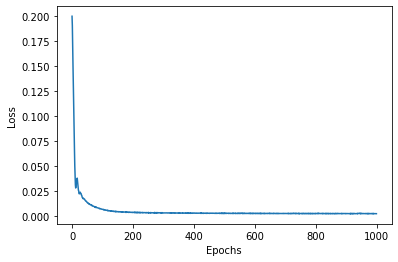

In [27]:
torch.cuda.empty_cache()
train_SRCNN(args)

In [ ]:
torch.cuda.empty_cache()
train_ESRGAN(args)

Using device: Tesla P100-PCIE-16GB
Number of parameters in G: 10720067
Number of parameters in D: 14499401
torch.Size([10, 3, 128, 128]) torch.Size([10, 3, 64, 64]) torch.Size([10, 3, 128, 128])
Iteration 0/100, G loss: 0.25028491020202637, D loss: 6.8137617111206055
torch.Size([10, 3, 128, 128]) torch.Size([10, 3, 64, 64]) torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128]) torch.Size([10, 3, 64, 64]) torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128]) torch.Size([10, 3, 64, 64]) torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128]) torch.Size([10, 3, 64, 64]) torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128]) torch.Size([10, 3, 64, 64]) torch.Size([10, 3, 128, 128])


KeyboardInterrupt: ignored